In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from astropy.time import Time
import warnings
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator

In [3]:
import sys

sys.path.append("../tools/")
from dust_extinction import calALambda
from data_binning import data_binning
from visual import rcparams_format

rcparams_format(mpl.rcParams)

color_map = {
    "green1": "#66c2a5",
    "orange": "#fc8d62",
    "blue": "#8da0cb",
    "pink": "#e78ac3",
    "green2": "#a6d854",
    "yellow": "#ffd92f",
    "brown": "#e5c494",
    "grey": "#b3b3b3",
    "darkgrey": "0.7"
}

In [4]:
print('NumPy version: {}'.format(np.__version__))
print('pandas version: {}'.format(pd.__version__))
print('matplotlib version: {}'.format(mpl.__version__))

NumPy version: 1.23.1
pandas version: 1.4.3
matplotlib version: 3.5.1


In [5]:
#%matplotlib notebook

In [6]:
# SN metadata

z = 0.02736
t_max_mjd = 59722.77 # B band
ebv = 0.032
rv = 3.1

# tfl = 58972.46296299994

In [7]:
def plot_box_spec(wave, flux):
    flux_plot = np.repeat(flux, 2)
    wv_plot = wave.copy()
    wv_plot[:-1] += np.diff(wave) / 2
    wv_plot = np.append(
        wave[0] - (wave[1] - wave[0]) / 2,
        np.append(np.repeat(wv_plot[0:-1], 2),
                  wave[-1] + (wave[-1] - wave[-2]) / 2))

    return wv_plot, flux_plot

In [8]:
spec_files = sorted(glob.glob('./data/ZTF*'))

In [9]:
import astropy.units as u
from spec_to_flux import spec_to_flux, spec_to_mag
flts = sorted(glob.glob('../photometry/filters/P48*'))
flts

['../photometry/filters/P48_I.dat',
 '../photometry/filters/P48_R.dat',
 '../photometry/filters/P48_g.dat']

## Spectral sequence

/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_8939/4154842931.py:31: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_8939/4154842931.py:31: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_8939/4154842931.py:31: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")


$\mathrm{FLOYDS}$ -12.149183974598644
$\mathrm{Kast}$ -0.3280252297145444
$\mathrm{SEDM}$ 2.5050584023454725
$\mathrm{SEDM}$ 2.5880499533660646
$\mathrm{SEDM}$ 7.301290297593338
$\mathrm{ALFOSC}$ 9.004604033640556
$\mathrm{SEDM}$ 19.967742368995108
$\mathrm{SPRAT}$ 21.597422519860437
$\mathrm{FLOYDS}$ 28.93561030213988
$\mathrm{SPRAT}$ 36.16479812335048
$\mathrm{Kast}$ 36.509110730417405
$\mathrm{LRIS}$ 36.60235360535974
$\mathrm{SEDM}$ 46.216726366567194
$\mathrm{ALFOSC}$ 60.46605863572961
$\mathrm{Binospec}$ 286.80518026787223
$\mathrm{LRIS}$ 329.7670427114186


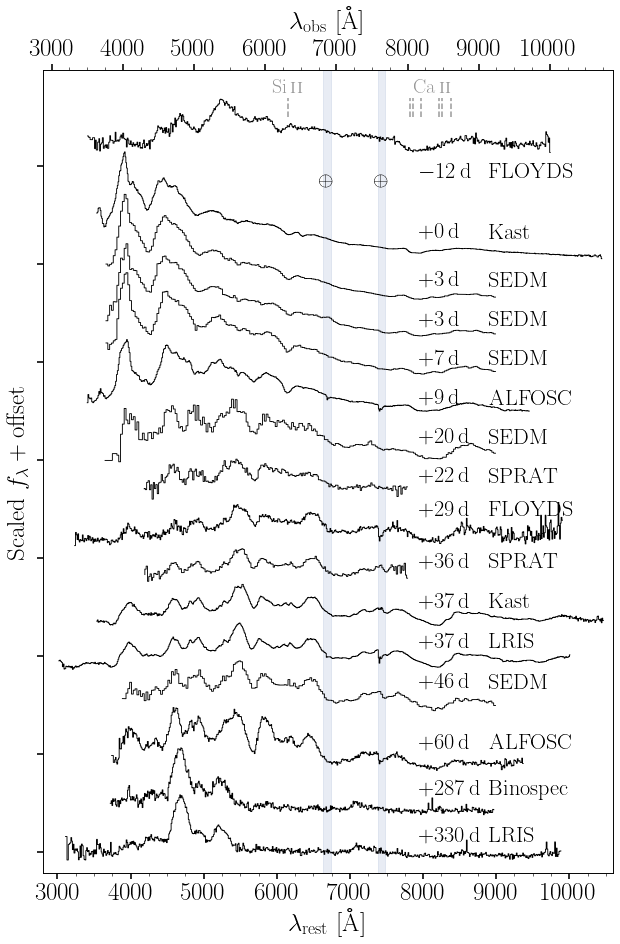

In [148]:
fig, ax = plt.subplots(figsize=(8.5, 13), constrained_layout=True)
spec_num = 0
phases_joj = []
for spec in spec_files:
    if "cal" in spec:
        continue
    if ("TSPEC" in spec) or ("bin" in spec):
        continue
    elif "Kast" in spec:
        instru = "Kast"
    elif "SEDM" in spec:
        instru = "SEDM"
    elif "SPRAT" in spec:
        instru = "SPRAT"
    elif "NOT" in spec:
        instru = "ALFOSC"
    elif "FLOYDS" in spec:
        instru = "FLOYDS"
    elif "Binospec" in spec:
        instru = "Binospec"
    elif "LRIS" in spec:
        instru = "LRIS"
    instru = "$\mathrm{" + instru + "}$"
    spec_df = pd.read_csv(spec, comment="#", delim_whitespace=True, header=None)

    try:
        fl_unc = spec_df[2].values
        if instru == "SEDM":
            fl_unc **= 0.5
    except:
        warnings.warn("No flux uncertainty in the datafile!")
        # set relative uncertainty to be 10%
        fl_unc = np.ones_like(spec_df[1].values) * 1e-1 * np.median(spec_df[1].values)
    with open(spec) as f:
        ll = f.readlines()
    # brute force
    mjd_found = False
    for l in ll:
        if "MJD_OBS" in l:
            mjd_obs = float(l.split(":")[1])
        elif "MJD" in l:
            mjd_obs = float(l.split("=")[1].split("/")[0])

    phase = (mjd_obs - t_max_mjd) / (1 + z)
    print(instru, phase)
    phases_joj.append(phase)
    # if ((phase > 100) and (not 'sub' in spec)):
    #     print(spec)
    #     continue
    spec_num += 1
    if mjd_obs < t_max_mjd:
        if mjd_obs + 1 < t_max_mjd:
            ax.text(
                7950,
                5 - 6.2 * spec_num,
                r"$-{:.0f}\,\mathrm d$".format(np.abs(phase)),
                fontsize=22.5,
            )
        else:
            ax.text(
                7950,
                5 - 6.2 * spec_num,
                r"$+{:.0f}\,\mathrm d$".format(np.abs(phase)),
                fontsize=22.5,
            )
        ax.text(8900, 5 - 6.2 * spec_num, instru, fontsize=22.5)
    elif mjd_obs < t_max_mjd + 25:
        ax.text(
            7950,
            -0.3 - 4 * spec_num,
            r"$+{:.0f}\,\mathrm d$".format(np.abs(phase)),
            fontsize=22.5,
        )
        ax.text(8900, -0.3 - 4 * spec_num, instru, fontsize=22.5)
    elif mjd_obs < t_max_mjd + 36:
        ax.text(
            7950,
            7.5 - 4.8 * spec_num,
            r"$+{:.0f}\,\mathrm d$".format(np.abs(phase)),
            fontsize=22.5,
        )
        ax.text(8900, 7.5 - 4.8 * spec_num, instru, fontsize=22.5)
    elif mjd_obs < t_max_mjd + 50:
        ax.text(
            7950,
            -4.1 * spec_num,
            r"$+{:.0f}\,\mathrm d$".format(np.abs(phase)),
            fontsize=22.5,
        )
        ax.text(8900, -4.1 * spec_num, instru, fontsize=22.5)
    else:
        ax.text(
            7950,
            7 - 4.75 * spec_num,
            r"$+{:.0f}\,\mathrm d$".format(np.abs(phase)),
            fontsize=22.5,
        )
        ax.text(8900, 7 - 4.75 * spec_num, instru, fontsize=22.5)

    fl_unc0 = fl_unc.copy()
    idx = spec_df[1].values > 0
    out = data_binning(
        np.array(
            [
                spec_df[0].values,
                spec_df[1].values,
                fl_unc,
            ]
        ).T[idx],
        size=10,
    )

    wv, fl = plot_box_spec(out[:, 0], out[:, 1])
    wv0, fl0 = plot_box_spec(
        spec_df[0].values[idx],
        spec_df[1].values[idx],
    )

    fl_unc = np.repeat(out[:, -1], 2)
    fl_unc0 = np.repeat(fl_unc0, 2)

    if "SPRAT" in instru:
        snr = 1
        bl, rd = 4300, np.inf
    else:
        snr = 1
        bl, rd = 0, np.inf
    # try:
    #     wv_cut0 = out[np.where(~((out[:, 0] >= bl)
    #                              | (out[:, 1] >= out[:, 2] * snr)))[0][-1], 0]
    # except IndexError:
    #     wv_cut0 = bl
    wv_cut0 = bl
    fl = fl[wv > wv_cut0]
    fl_unc = fl_unc[wv > wv_cut0]
    wv = wv[wv > wv_cut0]
    # try:
    #     wv_cut1 = out[np.where(~((out[:, 0] <= rd)
    #                              | (out[:, 1] >= out[:, 2] * snr)))[0][0], 0]
    # except IndexError:
    #     wv_cut1 = rd
    wv_cut1 = rd
    fl = fl[wv < wv_cut1]
    fl_unc = fl_unc[wv < wv_cut1]
    wv = wv[wv < wv_cut1]

    E = 10 ** (0.4 * calALambda(wv, rv, ebv))
    E0 = 10 ** (0.4 * calALambda(wv0, rv, ebv))
    fl *= E
    if phase > 100:
        norm_flux = np.nanmax(fl[np.where((wv > 4600) & (wv < 4800))]) / 7
    elif np.abs(phase) < 10:
        norm_flux = np.nanmedian(fl[np.where((wv > 7300) & (wv < 7500))]) / 1.4
    else:
        norm_flux = np.nanmedian(fl[np.where((wv > 7300) & (wv < 7500))]) / 1.8
    if phase < -10:
        ax.plot(
            wv / (1 + z),
            fl / norm_flux - 4.2 * spec_num + 5.5,
            color="k",
            linewidth=0.9,
        )
        # ax.plot(
        #     wv0[(wv0 > wv_cut0) & (wv0 < wv_cut1)] / (1 + z),
        #     (fl0 * E0)[(wv0 > wv_cut0) & (wv0 < wv_cut1)] / norm_flux
        #     - 4.2 * spec_num
        #     + 5.5,
        #     color="grey",  # aam_colors['blue'],
        #     alpha=0.15,
        # )
    elif phase < 0:
        ax.plot(
            wv / (1 + z), fl / norm_flux - 3.75 * spec_num - 2, color="k", linewidth=0.9
        )
        # ax.plot(
        #     wv0[(wv0 > wv_cut0) & (wv0 < wv_cut1)] / (1 + z),
        #     (fl0 * E0)[(wv0 > wv_cut0) & (wv0 < wv_cut1)] / norm_flux
        #     - 3.75 * spec_num
        #     - 2,
        #     color="grey",  # aam_colors['blue'],
        #     alpha=0.15,
        # )
    elif phase < 10:
        ax.plot(
            wv / (1 + z), fl / norm_flux - 3.75 * spec_num - 3, color="k", linewidth=0.9
        )
        # ax.plot(
        #     wv0[(wv0 > wv_cut0) & (wv0 < wv_cut1)] / (1 + z),
        #     (fl0 * E0)[(wv0 > wv_cut0) & (wv0 < wv_cut1)] / norm_flux
        #     - 3.75 * spec_num
        #     - 3,
        #     color="grey",  # aam_colors['blue'],
        #     alpha=0.15,
        # )
    elif phase < 50:
        ax.plot(
            wv / (1 + z),
            fl / norm_flux - 4.25 * spec_num - 0.5,
            color="k",
            linewidth=0.9,
        )
        # ax.plot(
        #     wv0[(wv0 > wv_cut0) & (wv0 < wv_cut1)] / (1 + z),
        #     (fl0 * E0)[(wv0 > wv_cut0) & (wv0 < wv_cut1)] / norm_flux
        #     - 4.25 * spec_num
        #     - 0.5,
        #     color="grey",  # aam_colors['blue'],
        #     alpha=0.15,
        # )
    else:
        ax.plot(
            wv / (1 + z),
            fl / norm_flux - 4.7 * spec_num + 4,
            color="k",
            linewidth=0.9,
        )
        # ax.plot(
        #     wv0[(wv0 > wv_cut0) & (wv0 < wv_cut1)] / (1 + z),
        #     (fl0 * E0)[(wv0 > wv_cut0) & (wv0 < wv_cut1)] / norm_flux
        #     - 4.7 * spec_num
        #     + 4,
        #     color="grey",  # aam_colors['blue'],
        #     alpha=0.15,
        # )


ax.text(7633 / (1 + z), -2, r"$\oplus$", ha="center", fontsize=20)
ax.text(6867 / (1 + z), -2, r"$\oplus$", ha="center", fontsize=20)

ax.fill_between(
    [7633 / (1 + z) - 50, 7633 / (1 + z) + 50],
    [-90, -90],
    [30, 30],
    color=color_map["blue"],
    alpha=0.2,
)
ax.fill_between(
    [6867 / (1 + z) - 50, 6867 / (1 + z) + 50],
    [-90, -90],
    [30, 30],
    color=color_map["blue"],
    alpha=0.2,
)
# Ca ii and Si ii lines
C = 299792.458


def dlam_lam(v):
    return ((1 - v / C) / (1 + v / C)) ** 0.5


param_dic = {"linestyle": "--", "color": "0.6", "zorder": -10}
ax.text(
    s=r"$\mathrm{Si}\,\textsc{ii}$",
    x=6355 * dlam_lam(10000),
    y=7.5,
    fontsize=20,
    color="0.6",
    ha="center",
)
ax.plot([6355 * dlam_lam(10000), 6355 * dlam_lam(10000)], [5, 7], **param_dic)
ax.text(
    s=r"$\mathrm{Ca}\,\textsc{ii}$",
    x=8542 * dlam_lam(15000),
    y=7.5,
    fontsize=20,
    color="0.6",
    ha="center",
)
ax.plot([8498 * dlam_lam(25000), 8498 * dlam_lam(25000)], [5, 7], **param_dic)
ax.plot([8542 * dlam_lam(25000), 8542 * dlam_lam(25000)], [5, 7], **param_dic)
ax.plot([8662 * dlam_lam(25000), 8662 * dlam_lam(25000)], [5, 7], **param_dic)
ax.plot([8498 * dlam_lam(10000), 8498 * dlam_lam(10000)], [5, 7], **param_dic)
ax.plot([8542 * dlam_lam(10000), 8542 * dlam_lam(10000)], [5, 7], **param_dic)
ax.plot([8662 * dlam_lam(10000), 8662 * dlam_lam(10000)], [5, 7], **param_dic)

ax.set_xlim(2800, 10600)
ax.set_yticklabels([])
ax.set_ylabel(r"$\mathrm{Scaled}\ f_\lambda + \mathrm{offset}$")
ax.set_xlabel(r"$\lambda_\mathrm{rest}\ [\mathrm{\r{A}}]$")
ax.xaxis.set_minor_locator(MultipleLocator(250))
# ax.yaxis.set_major_locator(MultipleLocator(1))

# ax[1].set_xlim(3450, 9600)
ax.set_ylim(-72.2, 9.8)
ax.set_xticks(np.arange(3, 11) * 1000)
# ax[1].set_xticks(np.arange(4, 10) * 1000)
# ax[1].set_ylim(-h * (num + .5), h * 1.5)
# ax[1].set_yticklabels([])
# ax[1].set_ylabel('')
# ax[1].set_xlabel(r'$\lambda_\mathrm{rest}\ [\mathrm{\r{A}}]$',
#                  **{'fontname': 'Times New Roman'})
# ax[1].xaxis.set_minor_locator(MultipleLocator(250))

# ax[1].text(7633 / (1 + z) + 5, -0.52, r'$\oplus$', ha='center', fontsize=20)
# ax[1].text(6867 / (1 + z) + 40, -0.27, r'$\oplus$', ha='center', fontsize=20)
# ax[1].yaxis.set_major_locator(MultipleLocator(1))

# fig.subplots_adjust(left=0.06, bottom=0.051, top=0.953, right=0.991)
# fig.savefig('../paper/figures/NIR_spec_comp.pdf', bbox_inches='tight')

wv_obs = ax.twiny()
wv_obs.set_xlim(np.array(ax.get_xlim()) * (1 + z))
wv_obs.set_xticks(np.arange(3, 11) * 1000)
wv_obs.set_xlabel(r"$\lambda_\mathrm{obs}\ [\mathrm{\r{A}}]$", labelpad=10)
wv_obs.xaxis.set_minor_locator(MultipleLocator(250))

# fig.subplots_adjust(left=0.06, bottom=0.051, top=0.953, right=0.991)
# fig.tight_layout()

plt.savefig("../paper/figures/SN2022joj_spectral_sequence.pdf", bbox_inches="tight")

## Spectra comparison

In [46]:
# SN metadata

def loadtxt(spec):
    try:
        dat = np.loadtxt(spec)
        dat[0, 0] # test if data have been read
        
    except:
        dat = np.loadtxt(spec, delimiter=',')
    return dat


class SN_meta:
    def __init__(self, name, z, tmax, ebv, files, IR_thres=1.1e4, phases=[]):
        self.name = name
        self.z = z
        self.t_max_mjd = tmax
        self.ebv = ebv
        files = np.sort(files)
        
        self.NIRfiles = files[[(loadtxt(file)[-1, 0] > IR_thres) for file in files]]
        self.OPTfiles = files[[(loadtxt(file)[-1, 0] < IR_thres) for file in files]]
        self.OPTspec = []
        if len(phases) == 0:
            phases = np.empty_like(self.OPTfiles, dtype=float)
            for k, file in enumerate(self.OPTfiles):
                with open(file) as f:
                    lines = f.readlines()
                for l in lines:
                    if "phase" in l:
                        phases[k] = float(l.split("=")[-1])
                        break
                    if "MJD" in l:
                        phases[k] = (float(l.split("=")[-1].split("/")[0]) - self.t_max_mjd) / (
                            1 + self.z
                        )
                        break
        for k, file in enumerate(self.OPTfiles):
            dat = loadtxt(file)
            if ("Keck" in file) and len(dat[0]) > 3:
                fl_err = dat[:, 3]
            elif len(dat[0]) < 3:
                fl_err = np.ones_like(dat[:, 0]) * 1e-1
            else:
                fl_err = dat[:, 2]
            ExtMW = 10 ** (0.4 * calALambda(dat[:, 0], EBV=self.ebv, RV=3.1))
            self.OPTspec.append(
                np.array(
                    [
                        dat[:, 0] / (1 + self.z),
                        dat[:, 1] * (1 + self.z) * ExtMW,
                        fl_err * (1 + self.z) * ExtMW,
                    ]
                ).T
            )
        self.phases = phases

### Peak

In [71]:
by = SN_meta(
    "SN\,1999by",
    z=0.002128,
    tmax=np.nan,
    ebv=0.016,
    files=glob.glob("./SN1999by/*.flm"),
)
aa = SN_meta(
    "SN\,1999aa", z=0.014907, tmax=np.nan, ebv=0.035, files=glob.glob("./SN1999aa/*")
)
T = SN_meta(
    "SN\,1991T", z=0.005777, tmax=np.nan, ebv=0.019, files=glob.glob("./SN1991T/*")
)
cx = SN_meta(
    "SN\,2000cx", z=0.008076, tmax=np.nan, ebv=0.072, files=glob.glob("./SN2000cx/*")
)
aoz = SN_meta(
    "SN\,2018aoz", z=0.00580, tmax=58221.41, ebv=0.093, files=glob.glob("./SN2018aoz/*")
)
fe = SN_meta(
    "SN\,2011fe", z=0.0008, tmax=np.nan, ebv=0.008, files=glob.glob("./SN2011fe/*")
)
joj = SN_meta('SN\,2022joj',
              z=0.0242,
              tmax=t_max_mjd,
              ebv=0.04,
              files=glob.glob('./data/ZTF22*'), phases=phases_joj)
cnw = SN_meta('SN\,2018cnw',
              z=0.02736,
              tmax=58302,
              ebv=0.024,
              files=glob.glob('./SN2018cnw/ZTF*'))

In [72]:
for target in [joj, by, aa, T, cx, fe, aoz, cnw]:
    print(target.name)
    print(target.phases)

SN\,2022joj
[-12.149183974598644, -0.3280252297145444, 2.5050584023454725, 2.5880499533660646, 7.301290297593338, 9.004604033640556, 19.967742368995108, 21.597422519860437, 28.93561030213988, 36.16479812335048, 36.509110730417405, 36.60235360535974, 46.216726366567194, 60.46605863572961, 286.80518026787223, 329.7670427114186]
SN\,1999by
[ -5.   -4.   -3.   -2.    2.    3.    4.    5.    6.    7.    8.   10.
  11.   25.   29.   31.   33.   42.  183.5]
SN\,1999aa
[2.40e-01 4.30e+01 2.56e+02 2.82e+02]
SN\,1991T
[ -9.11   6.8   41.   318.  ]
SN\,2000cx
[ -4.46   0.89   4.46   5.46   6.45   8.43  10.42  13.39  18.35  21.33
  23.32  25.3   27.28  29.27  30.69  40.6   60.41  70.3   88.13  96.06
 123.73 145.52 448.22]
SN\,2011fe
[-3.00e-01  7.00e-01  2.37e+01  4.08e+01  2.89e+02  3.13e+02]
SN\,2018aoz
[-10.95645258  -7.08888447  -7.0689998    7.74507854   7.75502088
  37.55219726  39.46112547]
SN\,2018cnw
[232.17540784]


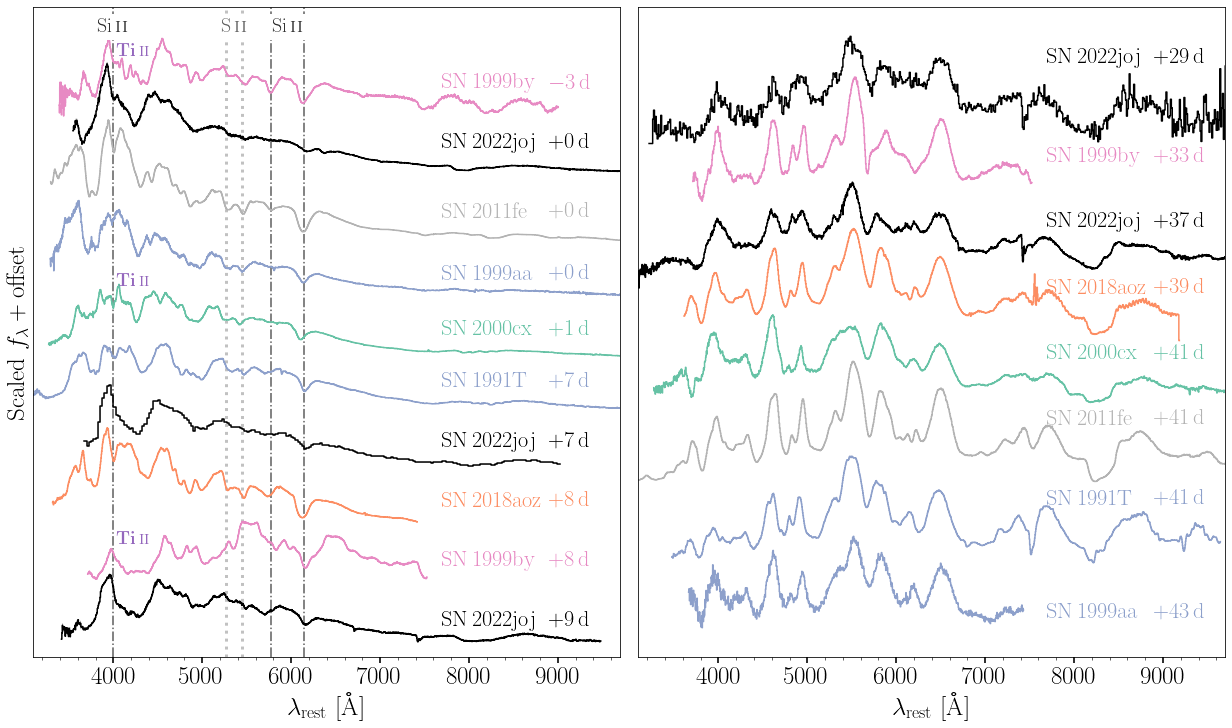

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(17, 10), sharex=True, constrained_layout=True)

# peak
# 99by -3d (2)
# 22joj -0d (1)
# 11fe +0d (0)
# 99aa +0d (0)
# 00cx +1d (1)
# 91T +7d (1)
# 22joj +7d (4)
# 18aoz +8d (3)
# 99by +8d (10)
# 22joj +9d (5)

idx = [2, 1, 0, 0, 1, 1, 4, 3, 10, 5]
targets = [by, joj, fe, aa, cx, T, joj, aoz, by, joj]
colors = [
    color_map["pink"],
    "k",
    "0.7",
    color_map["blue"],
    color_map["green1"],
    color_map["blue"],
    "k",
    color_map["orange"],
    color_map["pink"],
    "k",
]
h = 1.5
for k, (i, target, col) in enumerate(zip(idx, targets, colors)):
    spec = target.OPTspec[i]
    spec_bin = data_binning(spec, size=3)
    wv, fl = plot_box_spec(spec[:, 0], spec[:, 1])
    if target == joj:
        wv_bin, fl_bin = plot_box_spec(spec_bin[:, 0], spec_bin[:, 1])
    else:
        wv_bin, fl_bin = wv, fl
    norm = np.median(spec[(spec[:, 0] > 4500) & (spec[:, 0] < 6500), 1])
    ax[0].plot(
        wv,
        fl / norm / (1 + (target == aa) * 0.25)
        - h * k
        - (target == fe) * 0.25
        - (target == aa) * 0.1
        - (target == cx) * 0.17,
        color=col,
        alpha=0.3,
        lw=0.6,
    )
    ax[0].plot(
        wv_bin,
        fl_bin / norm / (1 + (target == aa) * 0.25)
        - h * k
        - (target == fe) * 0.25
        - (target == aa) * 0.1
        - (target == cx) * 0.17,
        color=col,
        lw=1.5,
    )
    ax[0].text(
        7700,
        -1.02 * h * (k - 0.5)
        - (target == fe) * 0.25
        - (target == aa) * 0.3
        - (target == cx) * 0.2,
        r"$\mathrm{" + target.name + r"}$",
        color=col,
        fontsize=22.5,
    )
    if target.phases[i] + 0.5 < 0:
        phase_text = r"${:.0f}".format(target.phases[i]) + r"\,\mathrm{d}$"
    else:
        phase_text = r"$+{:.0f}".format(np.abs(target.phases[i])) + r"\,\mathrm{d}$"
    ax[0].text(
        8900,
        -1.02 * h * (k - 0.5)
        - (target == fe) * 0.25
        - (target == aa) * 0.3
        - (target == cx) * 0.2,
        phase_text,
        color=col,
        fontsize=22.5,
    )


# Si ii
param_dic = {"linestyle": "-.", "color": "0.2", "zorder": -10, "lw": 1.5, "alpha": 0.8}
text_dic = {"facecolor": "white", "alpha": 1, "lw": 0}
ax[0].text(
    s=r"$\mathrm{Si}\,\textsc{ii}$",
    x=(6355 + 5972) / 2 * dlam_lam(10000),
    y=h + 0.7,
    fontsize=20,
    color="0.2",
    ha="center",
    bbox=text_dic,
)
ax[0].text(
    s=r"$\mathrm{Si}\,\textsc{ii}$",
    x=4128 * dlam_lam(10000),
    y=h + 0.7,
    fontsize=20,
    color="0.2",
    ha="center",
    bbox=text_dic,
)
# ax[0].plot([6355 * dlam_lam(10000), 6355 * dlam_lam(10000)], [-h * len(targets), h + .05],
#         **param_dic)
# ax[0].plot([5972 * dlam_lam(10000), 5972 * dlam_lam(10000)], [-h * len(targets), h + .05],
#         **param_dic)
# ax[0].plot([4128 * dlam_lam(10000), 4128 * dlam_lam(10000)], [-h * len(targets), h + .05],
#         **param_dic)
ax[0].axvline(6355 * dlam_lam(10000), **param_dic)
ax[0].axvline(5972 * dlam_lam(10000), **param_dic)
ax[0].axvline(4128 * dlam_lam(10000), **param_dic)

# S ii
param_dic = {
    "linestyle": ":",
    "color": "0.4",
    "zorder": -10,
    "lw": 3,
    "alpha": 0.4,
}
text_dic = {"facecolor": "white", "alpha": 1, "lw": 0}
ax[0].text(
    s=r"$\mathrm{S}\,\textsc{ii}$",
    x=(5647 + 5433) / 2 * dlam_lam(10000),
    y=h + 0.7,
    fontsize=20,
    color="0.4",
    ha="center",
    bbox=text_dic,
)
# ax[0].plot([(5647 + 5640 + 5606)/3 * dlam_lam(10000), (5647 + 5640 + 5606)/3 * dlam_lam(10000)], [-h * len(targets), h + .4],
#         **param_dic)
# ax[0].plot([(5433 + 5454)/2 * dlam_lam(10000), (5433 + 5454)/2 * dlam_lam(10000)], [-h * len(targets), h + .4],
#         **param_dic)
ax[0].axvline((5647 + 5640 + 5606) / 3 * dlam_lam(10000), **param_dic)
ax[0].axvline((5433 + 5454) / 2 * dlam_lam(10000), **param_dic)

ax[0].set_ylim(-h * (len(targets) - 0.8), None)

# Ti ii
ax[0].text(
    s=r"$\mathbf{Ti}\,\textsc{ii}$", x=4030, y=h + 0.1, color="tab:purple", fontsize=18
)
ax[0].text(
    s=r"$\mathbf{Ti}\,\textsc{ii}$",
    x=4030,
    y=-3 * h + 0.2,
    color="tab:purple",
    fontsize=18,
)
ax[0].text(
    s=r"$\mathbf{Ti}\,\textsc{ii}$",
    x=4030,
    y=-7 * h - 0.4,
    color="tab:purple",
    fontsize=18,
)
# ax[1].text(
#     s=r"$\mathbf{Ti}\,\textsc{ii}$", x=4060, y=-0.1, color="tab:purple", fontsize=18
# )

# transitional
# 22joj +29d (8)
# 99by +33d (16)
# 22joj +36d (11)
# 18aoz +39d (6)
# 00cx +41d (15)
# 11fe +41 (3)
# 91T +41d (2)
# 99aa +43d (1)

idx = [8, 16, 11, 6, 15, 3, 2, 1]
targets = [joj, by, joj, aoz, cx, fe, T, aa]
colors = [
    "k",
    color_map["pink"],
    "k",
    color_map["orange"],
    color_map["green1"],
    "0.7",
    color_map["blue"],
    color_map["blue"],
]
h = 1.4
for k, (i, target, col) in enumerate(zip(idx, targets, colors)):
    spec = target.OPTspec[i]
    if k == 0:
        spec_bin = data_binning(spec, size=10)
    else:
        spec_bin = data_binning(spec, size=3)
    wv, fl = plot_box_spec(spec[:, 0], spec[:, 1])
    wv_bin, fl_bin = plot_box_spec(spec_bin[:, 0], spec_bin[:, 1])
    norm = np.median(spec[(spec[:, 0] > 4000) & (spec[:, 0] < 5500), 1])
    # ax[1].plot(wv, fl / norm - h * (k + 0.4 * (target == T)),, color=col, alpha=0.15, lw=0.6)
    ax[1].plot(
        wv_bin, fl_bin / norm - h * (k + 0.6 * (target in [T, aa]) + 0.25 * (target==fe)), color=col, lw=1.5
    )
    ax[1].text(
        7700,
        -h
        * (1 + (target == T) * 0.04 + (target == aa) * 0.15 + (target.phases[i] < 30) * 0.7)
        * (k - 0.72),
        r"$\mathrm{" + target.name + r"}$",
        color=col,
        fontsize=22.5,
    )
    if target.phases[i] < 0:
        phase_text = r"${:.0f}".format(target.phases[i]) + r"\,\mathrm{d}$"
    else:
        phase_text = r"$+{:.0f}".format(target.phases[i]) + r"\,\mathrm{d}$"
    ax[1].text(
        8900,
        -h
        * (1 + (target == T) * 0.04 + (target == aa) * 0.15 + (target.phases[i] < 30) * 0.7)
        * (k - 0.72),
        phase_text,
        color=col,
        fontsize=22.5,
    )
ax[0].set_xlim(3100, 9700)

ax[0].set_yticks([])
ax[0].set_ylabel(r"$\mathrm{Scaled}\ f_\lambda + \mathrm{offset}$")
ax[0].set_xlabel(r"$\lambda_\mathrm{rest}\ [\mathrm{\r{A}}]$")

ax[1].set_yticks([])
# ax[1].set_ylabel(r'$\mathrm{Scaled}\ f_\lambda + \mathrm{offset}$')
ax[1].set_xlabel(r"$\lambda_\mathrm{rest}\ [\mathrm{\r{A}}]$")
ax[1].xaxis.set_minor_locator(MultipleLocator(200))
ax[1].xaxis.set_major_locator(MultipleLocator(1000))

fig.savefig("../paper/figures/spec_comp.pdf", bbox_inches="tight")

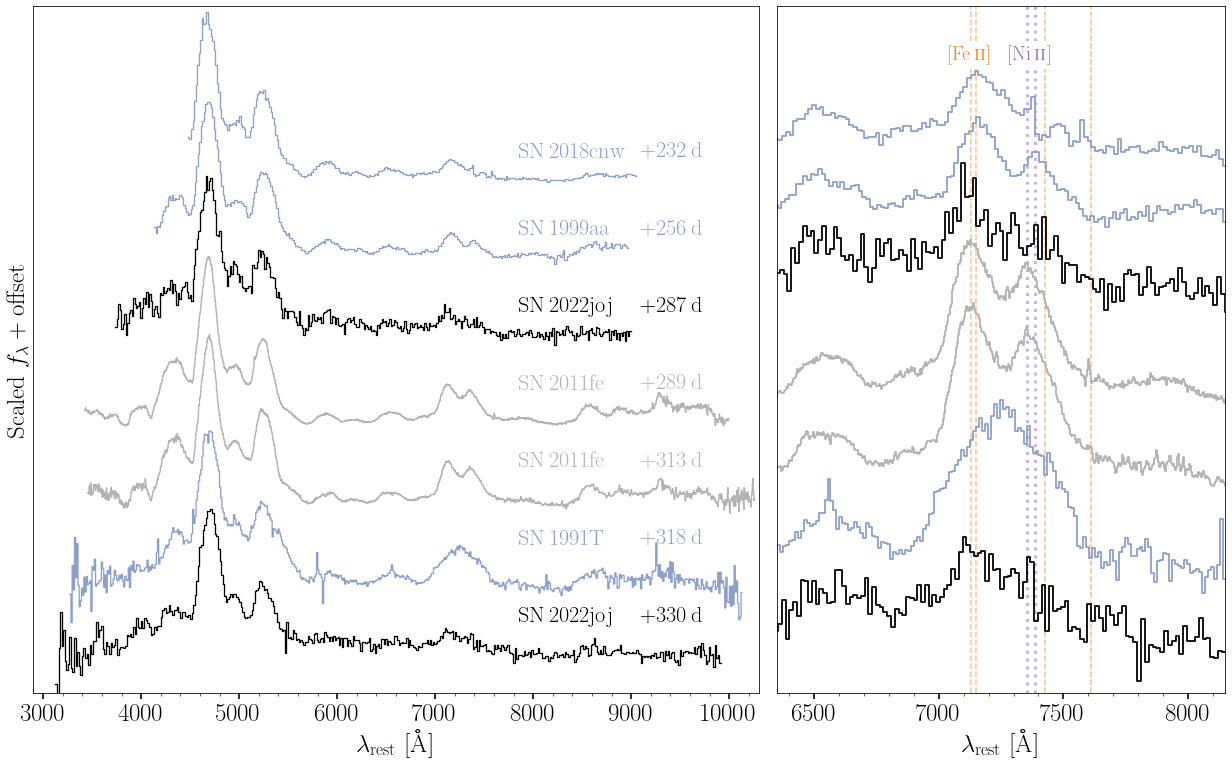

In [147]:
# nebular
# 18cnw +232d (0)
# 99aa +282d (-1)
# 22joj +286d (-2)
# 11fe +289d (-2)
# 11fe +313d (-1)
# 91T +318d (-1)
# 22joj +329d (-1)
# 00cx +448d (-1)

fig = plt.figure(figsize=(17, 17*0.618), constrained_layout=True)
widths = [1, 0.618]
heights = [1]
gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths, height_ratios=heights)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

idx = [0, -2,  -2, -2, -1, -1, -1]
targets = [cnw, aa, joj, fe, fe, T, joj]
colors = [
    color_map["blue"],
    color_map["blue"],
    "k",
    "0.7",
    "0.7",
    color_map["blue"],
    "k",
    # color_map["green1"],
]
h = 0.56
for k, (i, target, col) in enumerate(zip(idx, targets, colors)):
    spec = target.OPTspec[i]
    if targets[k] in [cnw, joj]:
        spec_bin = data_binning(spec, size=15)
    elif not targets[k] in [fe]:
        spec_bin = data_binning(spec, size=10)
    else:
        spec_bin = data_binning(spec, size=2)
    # wv, fl = plot_box_spec(spec[:, 0], spec[:, 1])
    wv_bin, fl_bin = plot_box_spec(spec_bin[:, 0], spec_bin[:, 1])
    norm = np.median(spec[(spec[:, 0] > 4600) & (spec[:, 0] < 4800), 1])
    # ax.plot(wv, fl / norm - h * k, color=col, alpha=0.15, lw=0.6)
    ax1.plot(wv_bin, fl_bin / norm - h * k, color=col, lw=1.3)
    ax1.text(
        7850,
        -h * 0.95 * (k - 0.33),
        r"$\mathrm{" + target.name + r"}$",
        color=col,
        fontsize=22.5,
    )
    if target.phases[i] < 0:
        phase_text = r"${:.0f}".format(target.phases[i]) + r"\,\mathrm{d}$"
    else:
        phase_text = r"$+{:.0f}".format(target.phases[i]) + r"\,\mathrm{d}$"
    ax1.text(
        9100,
        -h * 0.95 * (k - 0.33),
        phase_text,
        color=col,
        fontsize=22.5,
    )

    # wv, fl = plot_box_spec(spec[:, 0], spec[:, 1])
    wv_bin, fl_bin = plot_box_spec(spec_bin[:, 0], spec_bin[:, 1])
    # ax.plot(wv, fl / norm - h * k, color=col, alpha=0.15, lw=0.6)
    ax2.plot(wv_bin, fl_bin / norm - h / 4 * (k + 0.6 * (k == len(idx) - 1)), color=col, lw=1.8)

ax1.set_xlim(2900, 10300)
ax1.set_ylim(-h * (len(idx) - 1) - 0.15, h + 0.65)

ax1.set_yticks([])
ax1.set_ylabel(r"$\mathrm{Scaled}\ f_\lambda + \mathrm{offset}$")
ax1.set_xlabel(r"$\lambda_\mathrm{rest}\ [\mathrm{\r{A}}]$")
ax1.xaxis.set_minor_locator(MultipleLocator(200))
ax1.xaxis.set_major_locator(MultipleLocator(1000))

ax2.set_xlim(6350, 8150)
ax2.set_ylim(-h / 4 * (len(idx) - 1) - 0.05, h / 4 + 0.13)

ax2.set_yticks([])
ax2.set_xlabel(r"$\lambda_\mathrm{rest}\ [\mathrm{\r{A}}]$")
ax2.xaxis.set_minor_locator(MultipleLocator(100))
ax2.xaxis.set_major_locator(MultipleLocator(500))

# [Fe ii]
param_dic = {"linestyle": "--", "color": "tab:orange", "zorder": -10, "lw": 1.5, "alpha": 0.5}
text_dic = {"facecolor": "white", "alpha": 1, "lw": 0}
ax2.text(
    s=r"$[\mathrm{Fe}\,\textsc{ii}]$",
    x=7155 * dlam_lam(1000),
    y=h / 4 + 0.04,
    fontsize=20,
    color="tab:orange",
    ha="center",
    bbox=text_dic,
)
ax2.axvline(7155 * dlam_lam(1000), **param_dic)
ax2.axvline(7172 * dlam_lam(1000), **param_dic)
ax2.axvline(7453 * dlam_lam(1000), **param_dic)
ax2.axvline(7638 * dlam_lam(1000), **param_dic)

# [Ni ii]
param_dic = {
    "linestyle": ":",
    "color": "tab:purple",
    "zorder": -10,
    "lw": 3,
    "alpha": 0.5,
}
text_dic = {"facecolor": "white", "alpha": 1, "lw": 0}
ax2.text(
    s=r"$[\mathrm{Ni}\,\textsc{ii}]$",
    x=(7378 + 7412) / 2 * dlam_lam(1000),
    y=h / 4 + 0.04,
    fontsize=20,
    color="tab:purple",
    ha="center",
    bbox=text_dic,
)
ax2.axvline(7378 * dlam_lam(1000), **param_dic)
ax2.axvline(7412 * dlam_lam(1000), **param_dic)

fig.savefig("../paper/figures/spec_comp_nebular.pdf", bbox_inches="tight")

### C II

In [100]:
def velocity_rf(lambda_rf, lambda_0):
    '''convert rest-frame wavelength to relative velocity'''
    c = 2.99792458e5
    v = c * ((lambda_rf / lambda_0)**2 - 1) / ((lambda_rf / lambda_0)**2 + 1)

    return v

/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_8939/3479816748.py:14: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")


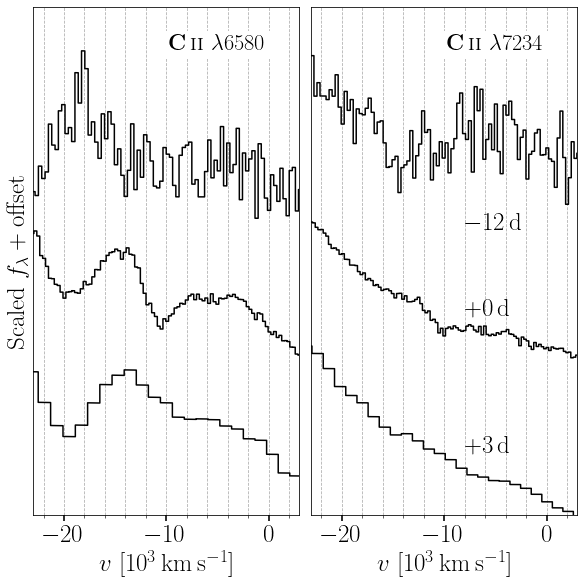

In [149]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8), sharex=True, constrained_layout=True)
spec_num = 0
phases_joj = []
for spec in spec_files[:3]:
    if "cal" in spec:
        continue
    spec_df = pd.read_csv(spec, comment="#", delim_whitespace=True, header=None)

    try:
        fl_unc = spec_df[2].values
        if instru == "SEDM":
            fl_unc **= 0.5
    except:
        warnings.warn("No flux uncertainty in the datafile!")
        # set relative uncertainty to be 10%
        fl_unc = np.ones_like(spec_df[1].values) * 1e-1 * np.median(spec_df[1].values)
    with open(spec) as f:
        ll = f.readlines()
    # brute force
    mjd_found = False
    for l in ll:
        if "MJD_OBS" in l:
            mjd_obs = float(l.split(":")[1])
        elif "MJD" in l:
            mjd_obs = float(l.split("=")[1].split("/")[0])

    phase = (mjd_obs - t_max_mjd) / (1 + z)
    phases_joj.append(phase)
    # if ((phase > 100) and (not 'sub' in spec)):
    #     print(spec)
    #     continue
    spec_num += 1
    if mjd_obs + 1 < t_max_mjd:
        ax[1].text(
            -8,
            2 - spec_num,
            r"$-{:.0f}\,\mathrm d$".format(np.abs(phase)),
            # fontsize=22.5,
        )
    else:
        ax[1].text(
            -8,
            2.5 - spec_num * 1.1,
            r"$+{:.0f}\,\mathrm d$".format(np.abs(phase)),
            # fontsize=22.5,
        )

    fl_unc0 = fl_unc.copy()
    idx = spec_df[1].values > 0
    out = data_binning(
        np.array(
            [
                spec_df[0].values,
                spec_df[1].values,
                fl_unc,
            ]
        ).T[idx],
        size=5,
    )

    wv, fl = plot_box_spec(out[:, 0], out[:, 1])
    wv0, fl0 = plot_box_spec(
        spec_df[0].values[idx],
        spec_df[1].values[idx],
    )

    fl_unc = np.repeat(out[:, -1], 2)
    fl_unc0 = np.repeat(fl_unc0, 2)

    E = 10 ** (0.4 * calALambda(wv, rv, ebv))
    E0 = 10 ** (0.4 * calALambda(wv0, rv, ebv))
    fl *= E
    norm_flux = np.nanmedian(fl[np.where((wv > 6000) & (wv < 7000))]) / 3.7
    for k in range(2):
        ax[k].plot(
            velocity_rf(wv / (1 + z), [6580, 7234][k]) / 1e3,
            fl / norm_flux - spec_num,
            color="k",
        )
        # ax[k].plot(
        #     velocity_rf(wv0[(wv0 > wv_cut0) & (wv0 < wv_cut1)] / (1 + z), [6580, 7234][k]) / 1e3,
        #     (fl0 * E0)[(wv0 > wv_cut0) & (wv0 < wv_cut1)] / norm_flux - spec_num,
        #     color="grey",  # aam_colors['blue'],
        #     alpha=0.15,
        # )

# C ii lines
C = 299792.458


def dlam_lam(v):
    return ((1 - v / C) / (1 + v / C)) ** 0.5


ax[0].text(
    s=r"$\mathbf{C}\,\textsc{ii}\ \lambda6580$",
    x=-5,
    y=3.67,
    color="k",
    fontsize=22.5,
    ha="center",
    bbox={"facecolor": "white", "alpha": 1, "lw": 0},
)
ax[1].text(
    s=r"$\mathbf{C}\,\textsc{ii}\ \lambda7234$",
    x=-5,
    y=2.45,
    color="k",
    fontsize=22.5,
    ha="center",
    bbox={"facecolor": "white", "alpha": 1, "lw": 0},
)

# param_dic = {"linestyle": "--", "color": "tab:grey", "zorder": -10}
# ax[0].axvline(6580 * dlam_lam(10000), **param_dic)
# ax[1].axvline(7234 * dlam_lam(10000), **param_dic)

ax[0].set_xlim(-23, 3)
# ax[1].set_xlim(6690, 7290)
ax[0].set_ylabel(r"$\mathrm{Scaled}\ f_\lambda + \mathrm{offset}$")
for a in ax:
    a.set_yticks([])
    a.set_xlabel(r"$v\ [10^3\,\mathrm{km\,s^{-1}}]$")
    a.xaxis.set_minor_locator(MultipleLocator(2))
    a.xaxis.set_major_locator(MultipleLocator(10))
    a.grid(which="both", linestyle="--")

ax[0].set_ylim(-0.08, 4.02)
ax[1].set_ylim(-1.3, 2.8)

# fig.subplots_adjust(left=0.06, bottom=0.051, top=0.953, right=0.991)
# fig.tight_layout()

plt.savefig("../paper/figures/C_II.pdf", bbox_inches="tight")

/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_8939/463798770.py:14: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")


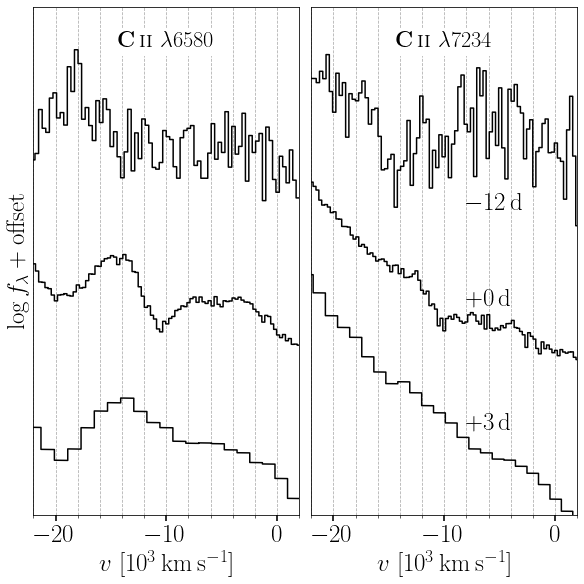

In [150]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8), sharex=True, constrained_layout=True)
spec_num = 0
phases_joj = []
for spec in spec_files[:3]:
    if "cal" in spec:
        continue
    spec_df = pd.read_csv(spec, comment="#", delim_whitespace=True, header=None)

    try:
        fl_unc = spec_df[2].values
        if instru == "SEDM":
            fl_unc **= 0.5
    except:
        warnings.warn("No flux uncertainty in the datafile!")
        # set relative uncertainty to be 10%
        fl_unc = np.ones_like(spec_df[1].values) * 1e-1 * np.median(spec_df[1].values)
    with open(spec) as f:
        ll = f.readlines()
    # brute force
    mjd_found = False
    for l in ll:
        if "MJD_OBS" in l:
            mjd_obs = float(l.split(":")[1])
        elif "MJD" in l:
            mjd_obs = float(l.split("=")[1].split("/")[0])

    phase = (mjd_obs - t_max_mjd) / (1 + z)
    phases_joj.append(phase)
    # if ((phase > 100) and (not 'sub' in spec)):
    #     print(spec)
    #     continue
    spec_num += 1
    if mjd_obs + 1 < t_max_mjd:
        ax[1].text(
            -8,
            -0.15 - spec_num / 6.7,
            r"$-{:.0f}\,\mathrm d$".format(np.abs(phase)),
            # fontsize=22.5,
        )
    else:
        ax[1].text(
            -8,
            -0.15 - spec_num * 1.1 / 9,
            r"$+{:.0f}\,\mathrm d$".format(np.abs(phase)),
            # fontsize=22.5,
        )

    fl_unc0 = fl_unc.copy()
    idx = spec_df[1].values > 0
    out = data_binning(
        np.array(
            [
                spec_df[0].values,
                spec_df[1].values,
                fl_unc,
            ]
        ).T[idx],
        size=5,
    )

    wv, fl = plot_box_spec(out[:, 0], out[:, 1])
    wv0, fl0 = plot_box_spec(
        spec_df[0].values[idx],
        spec_df[1].values[idx],
    )

    fl_unc = np.repeat(out[:, -1], 2)
    fl_unc0 = np.repeat(fl_unc0, 2)

    E = 10 ** (0.4 * calALambda(wv, rv, ebv))
    E0 = 10 ** (0.4 * calALambda(wv0, rv, ebv))
    fl *= E
    norm_flux = np.nanmedian(fl[np.where((wv > 6000) & (wv < 7000))])
    for k in range(2):
        ax[k].plot(
            velocity_rf(wv / (1 + z), [6580, 7234][k]) / 1e3,
            np.log10(fl / norm_flux) - spec_num / (7 + 4 * (k==1)),
            color="k",
        )
        # ax[k].plot(
        #     velocity_rf(wv0 / (1 + z), [6580, 7234][k]) / 1e3,
        #     np.log10((fl0 * E0) / norm_flux) - spec_num / (7 + 4 * (k==1)),
        #     color="grey",  # aam_colors['blue'],
        #     alpha=0.15,
        # )

# C ii lines
C = 299792.458


def dlam_lam(v):
    return ((1 - v / C) / (1 + v / C)) ** 0.5


# param_dic = {"linestyle": "--", "color": "tab:grey", "zorder": -10}
# ax[0].axvline(6580 * dlam_lam(10000), **param_dic)
# ax[1].axvline(7234 * dlam_lam(10000), **param_dic)

ax[0].set_xlim(-22, 2)
# ax[1].set_xlim(6690, 7290)
ax[0].set_ylabel(r"$\log f_\lambda + \mathrm{offset}$")
for a in ax:
    a.set_yticks([])
    a.set_xlabel(r"$v\ [10^3\,\mathrm{km\,s^{-1}}]$")
    a.xaxis.set_minor_locator(MultipleLocator(2))
    a.xaxis.set_major_locator(MultipleLocator(10))
    a.grid(which="both", linestyle="--")

ax[0].set_ylim(-0.5, -0.0)
ax[1].set_ylim(-0.6, -0.1)

ax[0].text(
    s=r"$\mathbf{C}\,\textsc{ii}\ \lambda6580$",
    x=-10,
    y=ax[0].get_ylim()[-1] - 0.04,
    color="k",
    fontsize=22.5,
    ha="center",
    bbox={"facecolor": "white", "alpha": 1, "lw": 0},
)
ax[1].text(
    s=r"$\mathbf{C}\,\textsc{ii}\ \lambda7234$",
    x=-10,
    y=ax[1].get_ylim()[-1] - 0.04,
    color="k",
    fontsize=22.5,
    ha="center",
    bbox={"facecolor": "white", "alpha": 1, "lw": 0},
)

# fig.subplots_adjust(left=0.06, bottom=0.051, top=0.953, right=0.991)
# fig.tight_layout()

plt.savefig("../paper/figures/C_II.pdf", bbox_inches="tight")